# Projet IMA 201 - Water pixels 

### by Chems eddine Benaziza
### Supervised by: Christophe Kervazo

# Introduction
The goal of this jupyter notebook is to implement a code in python that generates superpixels. This jupyter is joined by a pdf for more theoritical understanding. 
This work is part of a project in the IMA201 subject, engineering cycle at Télécom Paris

**Note the reader :**
- The author of this notebook wanted to take into consideration some software good practices, the code is written in functions, and all functions have comments that expalin their role and their input/output. This is to make the code more readable and understandable. 
- It was run under a conda global environnement after installing needed libraries.
- Download it with the image and run the cells.

## Steps to make super pixels

First we list all the steps

*1)* Computation of the gradient of an image : a morphological
gradient

*2)* Definition of regular cells on the image centered on the
vertices of a regular grid we choose cell centers in the grid

*3)* selection of one marker per cell this method allows total
control over the number of SP with a strong impact on their
their size and shape if desired we compute the minima of the
gradient g, each minimum is a connected component,
composed of one or more pixels, truncatedd along the grid,

*4)* Spatial regularization of the gradient with the help of a
distance function

*5)* Application of the watershed transformation on the
regularized gradient defined in step 4 from the markers
defined in step2

In [1]:

import matplotlib.pyplot as plt
import skimage.io as skio
import skimage
import numpy as np
import skimage.morphology as morpho
import skimage.segmentation as seg
import cv2 
import math

c:\Users\chemo\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


Step one loading the image

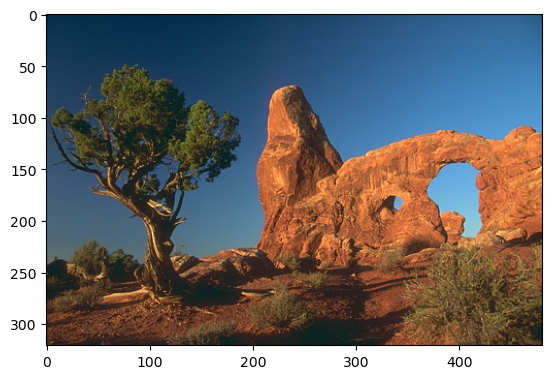

In [2]:
img = skio.imread('./landscape.jpg')
plt.imshow(img)
plt.show()

# 0 - Preprocessing with an opening and closing

This morphogical openning and closing will help us to smooth the image, so when we apply the gradient it will be more accurate.



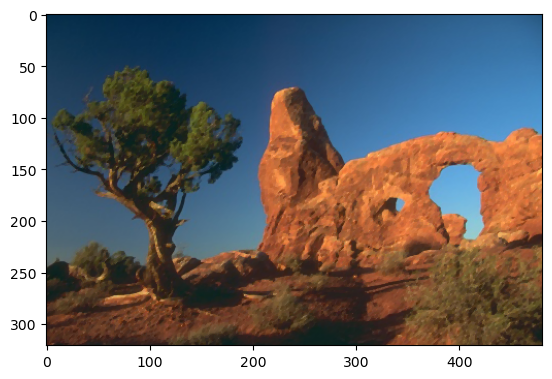

In [3]:
def open_close_smoothing(img,sigma):
    '''
    This function takes an image and a sigma value as input and 
    returns the smoothed image using a morphological opening and closing.
    '''

    img_test = np.asarray(img, dtype=np.uint8) # Specifying dtype is critical here
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(math.ceil(sigma*sigma/16),math.ceil(sigma*sigma/16)))
    opening = cv2.morphologyEx(img_test, cv2.MORPH_OPEN, kernel)
    closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)

    return closing

# apply the smoothing and show the result
plt.imshow(open_close_smoothing(img,5))
plt.show()

## 1  Extract Image gradient

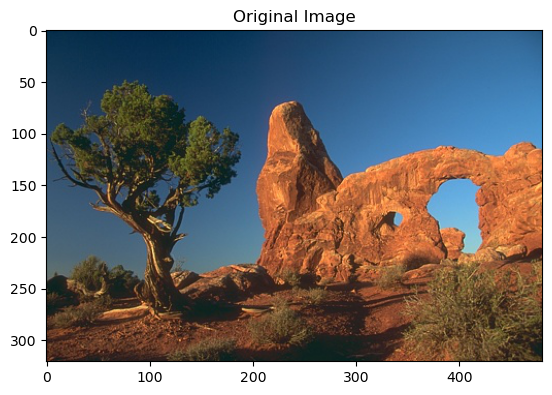

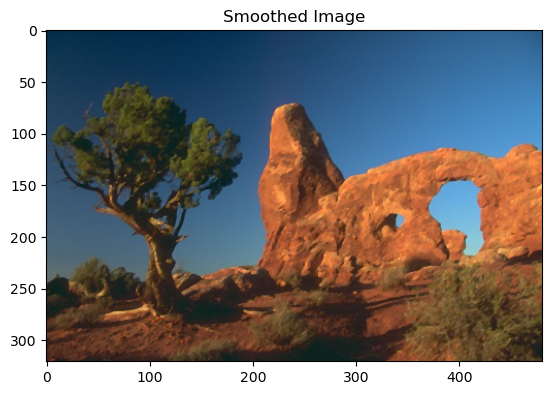

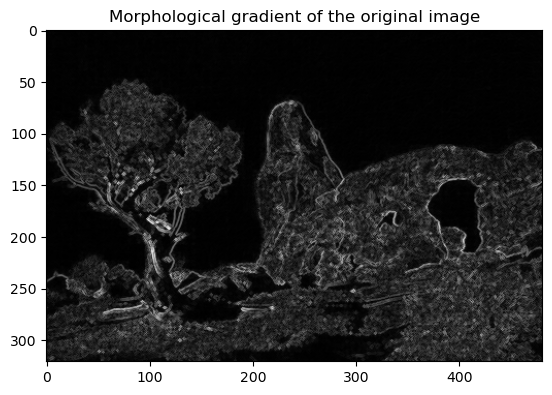

In [4]:

# Load the RGB image
img = skio.imread("./landscape.jpg")

# Display the original image
plt.imshow(img)
plt.title('Original Image')
plt.show()

# Create a copy of the image for processing
img_test = open_close_smoothing(img,5)
plt.imshow(img_test)
plt.title('Smoothed Image')
plt.show()
# Specify the radius parameter for disk
strell = morpho.disk(5)

def morpho_gradient(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    morpho_grad = morpho.dilation(img)- morpho.erosion(img)
    morpho_grad = morpho_grad.astype('int')
    return morpho_grad

# Apply the morphological gradient
img_grad = morpho_gradient(open_close_smoothing(img, 8))

# Display the image
plt.imshow(img_grad, cmap='gray')
plt.title('Morphological Gradient of a smoothed image open/close')
plt.show()

# i wanted to compare the morpholigical gradient of the original image and the smoothed one

img_grad_ori = morpho_gradient(img)

plt.imshow(img_grad_ori, cmap='gray')
plt.title("Morphological gradient of the original image")
plt.show()



# 2  Creating the grid

In [5]:
width = img.shape[0]
height = img.shape[1]
print(width, height)


321 481


In [6]:
# get the important points of the image
def get_grid_points(img, step):
    """
    Get the important points of the image, gets the grid points of the image
    """
    grid_points = []
    for i in range(0, img.shape[0], step):
        for j in range(0, img.shape[1], step):
            grid_points.append((i, j))
    return grid_points

In our case we need centers of the cells, this is why we go better use `get_grid_points_middles`

In [7]:

def get_grid_points_middles(img:np.ndarray, step : int)->np.ndarray:
    """
    the middle of each square of the grid
    """
    
    grid_points = []
    for l in range(0, img.shape[0], step):
        for c in range(0, img.shape[1], step):
            middle = (l + step//2, c + step//2)
            if middle[0] < img.shape[0] and middle[1] < img.shape[1]:
                grid_points.append(middle)

    grid_points_ar = np.zeros((len(grid_points), 2)).astype(int)
    
    for i in range(len(grid_points)):
        grid_points_ar[i] = grid_points[i]
    
    return grid_points_ar

### Application of the functions and display

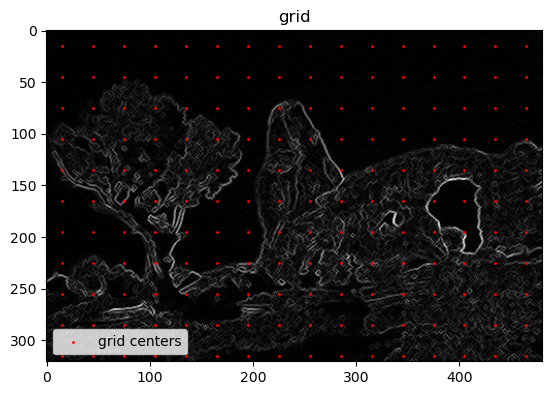

In [10]:
# testing the previous functions

sigma = 20
# calculating the gradient image
img_grad = morpho_gradient(open_close_smoothing(img,10**2/16))

grid_points = get_grid_points_middles(img_grad, step=30)

plt.imshow(img_grad, cmap='gray')

lines, cols = zip(*grid_points)
plt.scatter(x=cols, y =lines, c='r', s=1, label='grid centers')
plt.legend()
plt.title('grid')
plt.show()


# 3 selection of markers : 
- First we need to classify pixels according the squares they belong to 
- After that, we look for the minimum of the gradient in that square

for every cell, we look for the minimum of the gradient in that cell, or the group of connex pixels that are the minimum of the gradient in that cell



one of the possible implmentation of the varanoi tesselation algorithm is to to use the fortune algorithm.
https://fr.wikipedia.org/wiki/Diagramme_de_Vorono%C3%AF

In [11]:
def select_markers(img_grad, grid_points, step=20)-> np.ndarray:
    '''
    in each cell of the grid, select the point with the minimum gradient 

    '''

    n = len(grid_points)
    markers = np.empty((n, 2))

    print(markers.shape)
    for i in range(len(grid_points)):
        # get the minimum gradient in the cell
        min_grad = 255
        point = grid_points[i]

        for l in range(point[0]-step//2, point[0]+step//2):
            for c in range(point[1]-step//2, point[1]+step//2):

                if l < 0 or l >= img_grad.shape[0] or c < 0 or c >= img_grad.shape[1]:
                    continue

                if img_grad[l][c] < min_grad:
                    min_grad = img_grad[l][c]
                    min_point = (l, c)
        markers[i,0] = min_point[0]
        markers[i,1] = min_point[1]
    return markers


In [12]:
def select_markers_closest_to_center(img_grad: np.ndarray, grid_points:list, step=20)-> np.ndarray:
    '''
    in each cell of the grid, select the point with the minimum gradient 
    that is closest to the center of the cell
    '''

    n = len(grid_points)
    markers = np.empty((n, 2))
    print(markers.shape)
    for i in range(len(grid_points)):
        # get the minimum gradient in the cell
        min_grad = 255
        point = grid_points[i]
        smallest_distance = np.inf

        for l in range(point[0]-step//2, point[0]+step//2):
            for c in range(point[1]-step//2, point[1]+step//2):

                if l < 0 or l >= img_grad.shape[0] or c < 0 or c >= img_grad.shape[1]:
                    continue

                if img_grad[l][c] < min_grad and np.sqrt((l-point[0])**2 + (c-point[1])**2) < smallest_distance:
                    min_grad = img_grad[l][c]
                    min_point = (l, c)
                    smallest_distance = np.sqrt((l-point[0])**2 + (c-point[1])**2)

        markers[i,0] = min_point[0]
        markers[i,1] = min_point[1]
    return markers


#### Selecting group markers
In this part we will try to select tha biggest groupe of connex pixels taht are the minimum of the gradient in that cell

In [13]:
def select_group_markers(img_grad, grid_points, step=20):
    '''
    in each cell of the grid, select the point with the minimum gradient 
    '''
    grid = img_grad.copy()
    markers = []
    
    def grow_marker(l, c, dico,  value):
        '''given a line and column it gets all the connex component of the same value'''
        
        if l < 0 or l >= grid.shape[0] or c < 0 or c >= grid.shape[1]:
            return []
        elif grid[l][c] != value or grid[l][c] == -1:
            return []
        else:
            grid[l][c] = -1
            return [(l, c)] + grow_marker(l+1, c, dico, value) + grow_marker(l-1, c, dico, value) + grow_marker(l, c+1, dico, value) + grow_marker(l, c-1, dico, value) 


    for point in grid_points:
        # get the minimum gradient in the cell
        min_grad = 255
        
        dico = dict() # a dictionnary to store values of the minimum gradient in each cell

        for l in range(point[0]-step//2, point[0]+step//2):
            for c in range(point[1]-step//2, point[1]+step//2):

                if l < 0 or l >= img_grad.shape[0] or c < 0 or c >= img_grad.shape[1]:
                    continue

                if img_grad[l][c] < min_grad:
                    min_grad = img_grad[l][c]
                    if img_grad[l][c] in dico:
                        #dico[img_grad[l][c]].append(grow_marker(l, c, dico, img_grad[l][c]))
                        dico[img_grad[l][c]] = dico[img_grad[l][c]] + grow_marker(l, c, dico, img_grad[l][c])
                    else :
                        dico[img_grad[l][c]] = []
                        dico[img_grad[l][c]] = dico[img_grad[l][c]] + grow_marker(l, c, dico, img_grad[l][c])
     
             
        max_len = 0
        for key in dico:
            if len(dico[key]) > max_len:
                marker = dico[key]
                max_len = len(dico[key])
        markers.append(marker)
    return markers

### Testing the group markers


Due to the complexity of using a lot of markers per cell, we will not use this method of the biggest group of connex pixels that are the minimum of the gradient in that cell. But wepresent the code that makes it possible to extract biggest flat components in a cell.

[[(0, 0), (1, 0), (0, 1)], [(0, 40), (1, 40), (2, 40), (3, 40), (3, 39), (4, 39), (2, 39), (1, 39), (0, 39), (0, 38), (1, 38), (2, 38), (3, 38), (2, 37), (1, 37), (0, 37), (0, 36), (2, 41), (1, 41), (0, 41), (1, 42)], [(0, 80), (0, 79), (1, 79), (1, 78), (2, 78), (2, 77), (1, 77), (0, 77), (0, 78), (0, 76), (1, 76), (2, 76), (2, 75), (0, 75)], [(0, 120)], [(0, 164), (0, 165), (1, 165), (1, 166), (2, 166), (2, 167), (1, 167), (0, 167), (0, 168), (1, 168), (2, 168), (1, 169), (0, 169), (0, 170), (1, 170), (0, 171), (0, 166)], [(0, 200), (1, 200), (1, 201), (2, 201), (3, 201), (4, 201), (5, 201), (6, 201), (7, 201), (7, 200), (8, 200), (6, 200), (5, 200), (4, 200), (3, 200), (3, 199), (2, 199), (2, 198), (1, 198), (1, 197), (1, 196), (2, 196), (0, 196), (0, 195), (1, 195), (1, 194), (2, 194), (2, 193), (3, 193), (2, 192), (1, 192), (1, 191), (2, 191), (2, 190), (3, 190), (3, 189), (2, 189), (2, 188), (1, 188), (1, 187), (2, 187), (3, 187), (3, 186), (4, 186), (5, 186), (6, 186), (6, 185),

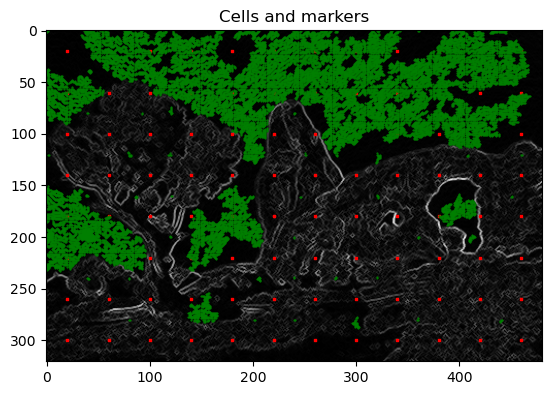

In [14]:
# testing the previous functions

plt.imshow(img_grad, cmap='gray')

grid_points = get_grid_points_middles(img_grad, step=40)
line_coords, col_coords= zip(*grid_points)
plt.scatter(x=col_coords, y =line_coords, marker='s', color='red', s=1, label='centers of the cells')



group_markers = select_group_markers(img_grad, grid_points, step=40)
print(group_markers)
    

for marker in group_markers:
    if len(marker) > 1:
        line_coords, col_coords= zip(*marker)
        plt.scatter(x=col_coords, y =line_coords, marker='o', color='green', s=0.3, label='markers - minimum gradient points')


plt.title('Cells and markers')

plt.show()



#### Taking the markers as the cell centers

(96, 2)


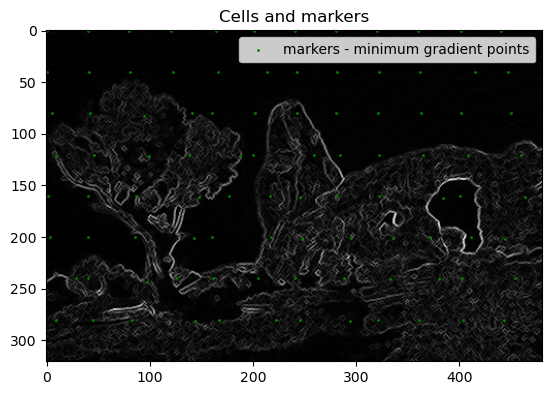

In [15]:
# testing the previous functions

plt.imshow(img_grad, cmap='gray')

markers = select_markers_closest_to_center(img_grad,grid_points,step=40)
line_coords, col_coords= zip(*markers)
plt.scatter(x=col_coords, y =line_coords, marker='o', color='green', s=1, label='markers - minimum gradient points')
plt.title('Cells and markers')
plt.legend()

plt.show()


# 4. Régularisation du gradient :
Every pixel of the gradient will have a diffeernt value depending on where it is located. The more it is far from the marker, the higher the value will be.


we design a spatially regularized gradient in order to further to further compormise between boundary adherence and regularityof the SPs


$$
\forall p \in D , d_Q(p) = \frac{2}{\sigma} \min_{i \in [1..N]} d(p,q_i)
$$


In this examples we are taking markers as centers, 

In [16]:
def get_nearest_center(point, centers, step:float=20):
    '''
    Get the nearest center of a point
    point : any point of the gradient
    centers : the centers of the cells of the grid
    step (sigma) : the step of the grid
    
    return : the nearest center and the distance between the point and the center
    warning : this is not an eucledean distance it is normalized 
    '''
    min_dist = np.inf
    nearest_center = None
    
    for center in centers:
        #dist = np.linalg.norm(np.array(point) - np.array(center))
        dist = math.sqrt((point[0]-center[0])**2 + (point[1]-center[1])**2)
        if dist < min_dist:
            min_dist = dist
            nearest_center = center
    
    assert nearest_center is not None

    return nearest_center, 2*(min_dist/step) 

In [17]:
# test 
point = (100, 100)
centers = grid_points
nearest_center, dist = get_nearest_center(point, centers)
print(nearest_center, dist)

[100 100] 0.0


Associer à chaque pixel de l'image son marqueur le plus proche

In [18]:
def get_labeled_pixels(img_grad, markers, step=20):
# TO BE OPTIMIZED, IT TAKES A LOT OF TIME
    '''
    Get the labeled pixels of the image
    return : a matrix with the th size of the image added to that the nearerst center and the distance
    '''
    labeled_pixels = np.zeros((img_grad.shape[0], img_grad.shape[1], 3), dtype=np.float32)
    for l in range(img_grad.shape[0]):
        for c in range(img_grad.shape[1]): 
            nearest_center, dist = get_nearest_center((l, c), markers, step)
            labeled_pixels[l, c, 0] = nearest_center[0]
            labeled_pixels[l, c , 1] = nearest_center[1]
            labeled_pixels[l, c, 2] = dist

    return labeled_pixels

In [19]:


def get_labeled_pixels_bis(img_grad, step=20):
# OPTIMIZED
    '''
    Get the labeled pixels of the image
    return : a matrix with the th size of the image added to that the nearerst center and the distance
    '''

    labeled_pixels = np.zeros((img_grad.shape[0], img_grad.shape[1], 3), dtype=np.uint16)
    for l in range(img_grad.shape[0]):
        for c in range(img_grad.shape[1]):
            grid_point = (l//step, c//step)
            labeled_pixels[l, c, 0] = grid_point[0]*step + step//2
            labeled_pixels[l, c , 1] = grid_point[1]*step + step//2
            #i want to normalize the distance

            dist = math.sqrt((l - labeled_pixels[l, c, 0])**2 + (c - labeled_pixels[l, c, 1])**2)*step/255
            # i want to normalize the  disntace to be between 0 and 1
            labeled_pixels[l, c, 2] = 255*dist/float(step)

    return labeled_pixels


The spacially regularized gradient is defined as follows 
$$
G_{reg} = G + k d_Q
$$

In [20]:
def get_regularized_gradient(img_grad, markers,k =4,  step=20):
    '''
    returns the regularized gradient of the image according 
    k : spacial regularization constant
    '''
    reg_grad = img_grad.copy().astype(float)
    for l in range(img_grad.shape[0]):
        for c in range(img_grad.shape[1]):
            nearest_center, dist = get_nearest_center((l, c), markers, step)
            reg_grad[l][c] = reg_grad[l][c] + k*dist
    return img_grad



### Labeled version
This version takes the labeled version of the image, here each pixel is associated to its marker

In [21]:
def get_regularized_grad_label(img_grad,pixel_labels, k = 4):
    '''
    returns the regularized gradient of the image according 
    k : spacial regularization constant
    '''
    reg_grad = np.empty_like(img_grad).astype('float')
    
    for l in range(img_grad.shape[0]):
        for c in range(img_grad.shape[1]):
            dist_to_center = pixel_labels[l][c][2]
            reg_grad[l][c] = img_grad[l][c] + k*dist_to_center
   
    mx = np.max(reg_grad) 

    normalized_reg_grad = (reg_grad/mx)*255
    
    return normalized_reg_grad


### Testing the distance map

(96, 2)
(321, 481, 3)


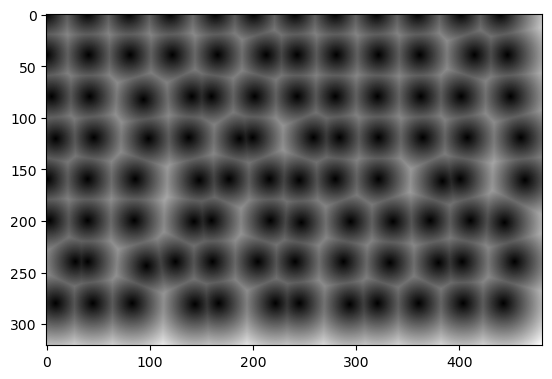

In [22]:
marks = select_markers_closest_to_center(img_grad, grid_points, step=40)
test_image = get_labeled_pixels(img_grad,marks, step=40)
#test_image = get_labeled_pixels_bis(img_grad, step=40)
print(test_image.shape)
plt.imshow(test_image[:, :, 2], cmap='gray')


### Result of the regularized gradient

(60, 2)


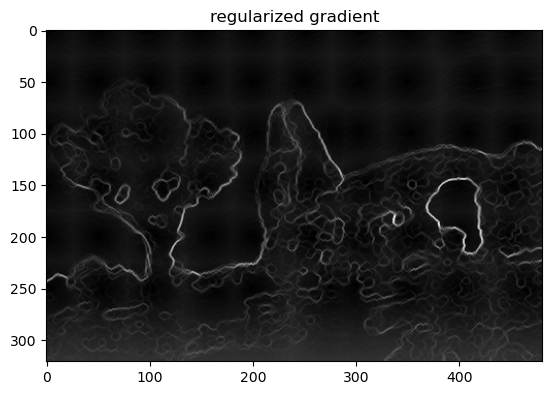

In [30]:
# testing the labeled pixels method 

img = skio.imread("./landscape.jpg")
img_grad = morpho_gradient(open_close_smoothing(img, 10))

plt.imshow(img_grad, cmap='gray')

grid_points = get_grid_points_middles(img_grad, step=50)
markers = select_markers_closest_to_center(img_grad, grid_points, step=50)
labels = get_labeled_pixels(img_grad,markers, step=50)


# calculating the regularized graident

regularized_grad = get_regularized_grad_label(img_grad, labels, k=8)
plt.imshow(regularized_grad, cmap='gray')
plt.title('regularized gradient')
plt.show()



# 5. Applying the watershed transformation

### Testing the distance transfomation 

In [31]:
def create_markers_image(img_grad , points_array, step=20):
    '''
    img_grad is three dimensional 
    create an image with the markers from a marker np array in the shape (nb_points, 2)
    '''
    #markers = np.zeros((img_grad.shape[0], img_grad.shape[1]), dtype=np.uint8)
    markers = np.zeros_like(img_grad[:, :, 0], dtype=np.int32)
    nb_points = points_array.shape[0]
    
    for i in range(nb_points):
        l = points_array[i, 0]
        c = points_array[i, 1]
        markers[int(l), int(c)] = 255
    
    return markers



#### Create markers image 
In order to apply the watershed transform, we had to create an image where some pixels are True, or at value 255, those pixels  are the markers

In [32]:
def create_markers_image(img_grad , points_array, step=20):
    '''
    img_grad is three dimensional 
    create an image with the markers from a marker np array in the shape (nb_points, 2)
    '''
    markers = np.zeros_like(img_grad[:, :], dtype=np.int32)
    nb_points = points_array.shape[0]
    
    for i in range(nb_points):
        l = points_array[i, 0]
        c = points_array[i, 1]
        markers[int(l), int(c)] = True
    
    return markers

In [33]:
def create_markers_image(img_grad, points_array, step=20):
    '''
    create an image with the markers from a marker np array in the shape (nb_points, 2)
    '''
    markers = np.zeros((img_grad.shape[0], img_grad.shape[1]), dtype=np.uint8)
    
    nb_points = points_array.shape[0]
    for i in range(nb_points):
        l = points_array[i, 0]
        c = points_array[i, 1]
        markers[int(l), int(c)] = 255
    return markers




## Apply the watershed

(321, 481, 3)


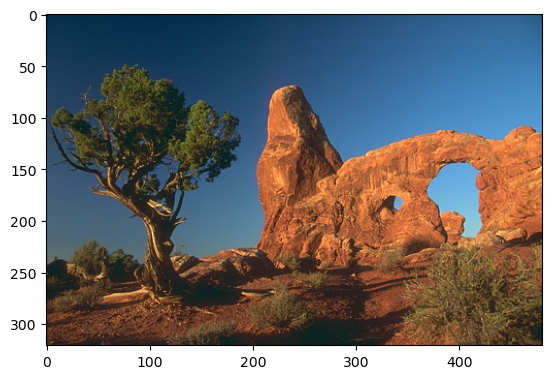

In [34]:
im = skio.imread('./landscape.jpg')
print(im.shape)

plt.figure()
plt.imshow(im)
plt.show()

(60, 2)


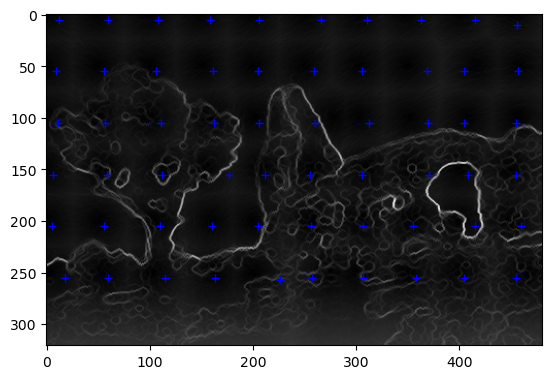

In [35]:

from skimage.filters import rank,gaussian
from skimage.morphology import disk
from skimage.feature import peak_local_max

markers = select_markers_closest_to_center(img_grad, grid_points, step=40)
plt.figure()
plt.imshow(regularized_grad, cmap='gray')
plt.plot(markers[:,1],markers[:,0],'b+')
plt.show()



(60, 2)


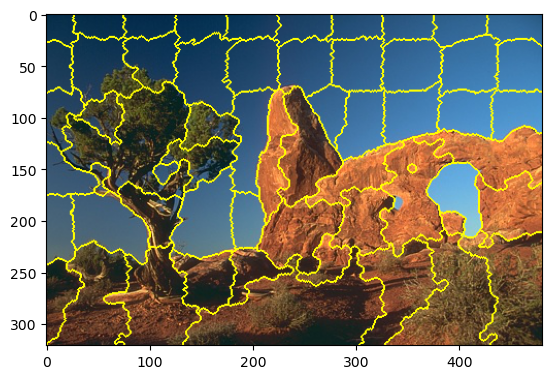

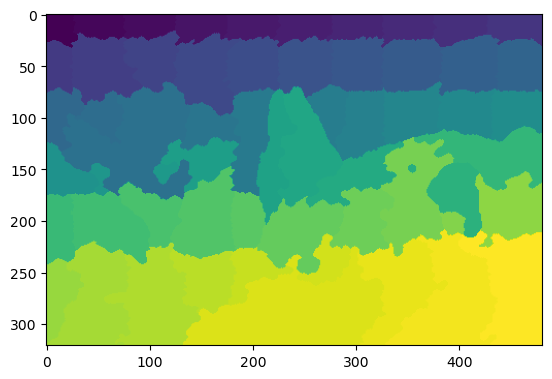

In [36]:
from skimage.segmentation import watershed
from skimage.segmentation import mark_boundaries
from skimage.measure import label

#list_markers_groups = select_group_markers(img_grad, grid_points, step=20)
#print(list_markers_groups.flatten())

markers_points = select_markers(img_grad, grid_points, step=50)
markers_image = create_markers_image(img_grad, markers_points, step=50)
markers = label(markers_image)
ws = watershed(regularized_grad, markers)

plt.figure()
plt.imshow(mark_boundaries(img,ws))
plt.figure()
plt.imshow(ws)
plt.show()

# Conclusion : Whole pipeline from smoothening to watershed 

In [37]:
import numpy as np
import skimage.io as skio
import matplotlib.pyplot as plt 
from skimage.segmentation import watershed, mark_boundaries
from time import process_time_ns, time
from skimage.measure import label


def waterpixel(img_path, smoothening=10, k=2, step=50):
    '''
    This function takes an image and a sigma value as input and
    k is the spacial regularization constant
    step is the step of the grid
    returns the waterpixeled images
    '''
    time1 = time()
    
    # loading the image

    im = skio.imread(img_path)
    if im is None:
        print("Error loading the image.")
        return
    # apply smoothening 
    im_smooth = open_close_smoothing(im,smoothening)
    print("time to smooth the image : ", time()-time1)
    # calculate the gradient
    img_grad = morpho_gradient(im_smooth)
    print("time to calculate the gradient : ", time()-time1)
    # testing the labeled pixels method 
    # get the points in the grid 
    grid_points = get_grid_points_middles(img_grad, step=step)
    print("time to get the grid points : ", time()-time1)
    #selecting the markers 
    markers_points = select_markers_closest_to_center(img_grad, grid_points, step=step)
    print("time to select the markers : ", time()-time1)
    labels = get_labeled_pixels(img_grad, markers_points, step=step)
    print("time to get the labels : ", time()-time1)
    regularized_grad = get_regularized_grad_label(img_grad, labels, k=k)
    print("time to regularize the gradient : ", time()-time1)
    markers_image = create_markers_image(img_grad, markers_points, step=50)
    print("time to create the markers image : ", time()-time1)
    markers = label(markers_image)
    print("time to label the markers : ", time()-time1)
    ws = watershed(regularized_grad, markers)
    print("time to apply the watershed : ", time()-time1)

    plt.figure()
    plt.imshow(mark_boundaries(im,ws))



    time2 = time()
    print("time for the preprocessing : ", time2 - time1)




Some time benchmarking 

time to smooth the image :  0.0
time to calculate the gradient :  0.010417461395263672
time to get the grid points :  0.010417461395263672
(176, 2)
time to select the markers :  0.0996391773223877
time to get the labels :  26.060202598571777
time to regularize the gradient :  26.45121669769287
time to create the markers image :  26.45121669769287
time to label the markers :  26.45121669769287
time to apply the watershed :  26.503111600875854
time for the preprocessing :  26.52721405029297
(176, 2)
time for the preprocessing :  24.112852811813354


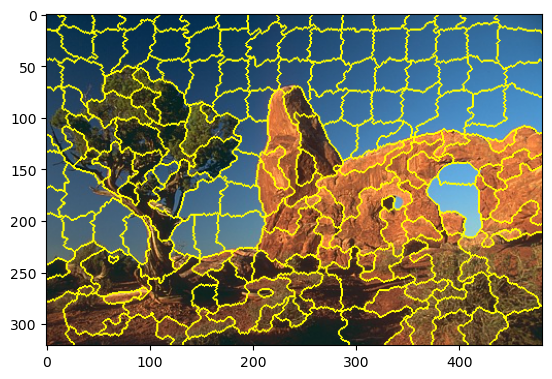

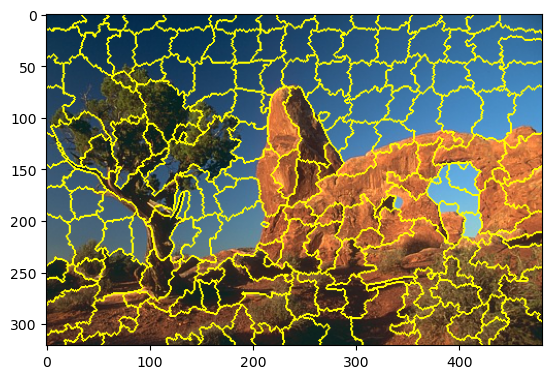

In [38]:
import numpy as np
import skimage.io as skio
import matplotlib.pyplot as plt 
from skimage.segmentation import watershed, mark_boundaries
from time import time
from skimage.measure import label


def waterpixel2(img_path, smoothening=10, k=2, step=50):
    '''
    This function takes an image and a sigma value as input and
    k is the spacial regularization constant
    step is the step of the grid
    returns the waterpixeled images
    '''
    time1 = time()
    
    # loading the image

    im = skio.imread(img_path)
    if im is None:
        print("Error loading the image.")
        return
    
    # apply smoothening 
    im_smooth = open_close_smoothing(im,smoothening)

    # calculate the gradient
    img_grad = morpho_gradient(im)

    # testing the labeled pixels method 
    # get the points in the grid 
    grid_points = get_grid_points_middles(img_grad, step=step)
    #selecting the markers 
    markers_points = select_markers_closest_to_center(img_grad, grid_points, step=step)
    
    labels = get_labeled_pixels(img_grad, markers_points, step=step)
    regularized_grad = get_regularized_grad_label(img_grad, labels, k=k)
    
    markers_image = create_markers_image(img_grad, markers_points, step=50)
    markers = label(markers_image)
    ws = watershed(regularized_grad, markers)

    plt.figure()
    plt.imshow(mark_boundaries(im,ws))



    time2 = time()
    print("time for the preprocessing : ", time2 - time1)


if __name__ == "__main__":
    waterpixel("./landscape.jpg", k = 3, step=30)
    waterpixel2("./landscape.jpg", k = 3, step=30)



# comparaison to some other code from the skimage library  

Felzenszwalb number of segments: 194
SLIC number of segments: 196
Quickshift number of segments: 695
Watershed number of segments: 256


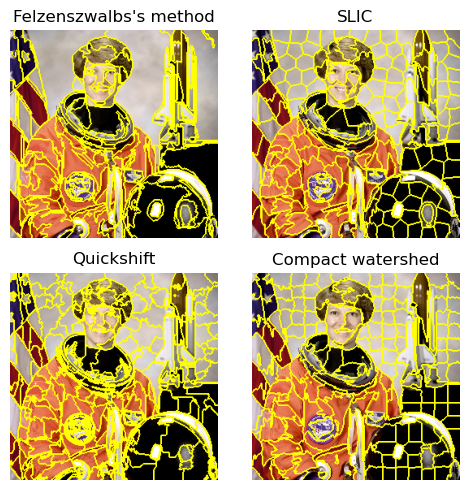

In [39]:
import matplotlib.pyplot as plt
import numpy as np

from skimage.data import astronaut
from skimage.color import rgb2gray
from skimage.filters import sobel
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float

img = img_as_float(astronaut()[::2, ::2])

segments_fz = felzenszwalb(img, scale=100, sigma=0.5, min_size=50)
segments_slic = slic(img, n_segments=250, compactness=10, sigma=1,
                     start_label=1)
segments_quick = quickshift(img, kernel_size=3, max_dist=6, ratio=0.5)
gradient = sobel(rgb2gray(img))
segments_watershed = watershed(gradient, markers=250, compactness=0.001)

print(f'Felzenszwalb number of segments: {len(np.unique(segments_fz))}')
print(f'SLIC number of segments: {len(np.unique(segments_slic))}')
print(f'Quickshift number of segments: {len(np.unique(segments_quick))}')
print(f'Watershed number of segments: {len(np.unique(segments_watershed))}')

fig, ax = plt.subplots(2, 2, figsize=(5, 5), sharex=True, sharey=True)

ax[0, 0].imshow(mark_boundaries(img, segments_fz))
ax[0, 0].set_title("Felzenszwalbs's method")
ax[0, 1].imshow(mark_boundaries(img, segments_slic))
ax[0, 1].set_title('SLIC')
ax[1, 0].imshow(mark_boundaries(img, segments_quick))
ax[1, 0].set_title('Quickshift')
ax[1, 1].imshow(mark_boundaries(img, segments_watershed))
ax[1, 1].set_title('Compact watershed')

for a in ax.ravel():
    a.set_axis_off()

plt.tight_layout()
plt.show()

here to finish this test https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_watershed.html